In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('Tweets.csv')

In [4]:
df.shape

(14640, 15)

In [35]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [37]:
df['text'].values[35]

'Nice RT @VirginAmerica: Vibe with the moodlight from takeoff to touchdown. #MoodlitMonday #ScienceBehindTheExperience http://t.co/Y7O0uNxTQP'

Text(0, 0.5, 'Count')

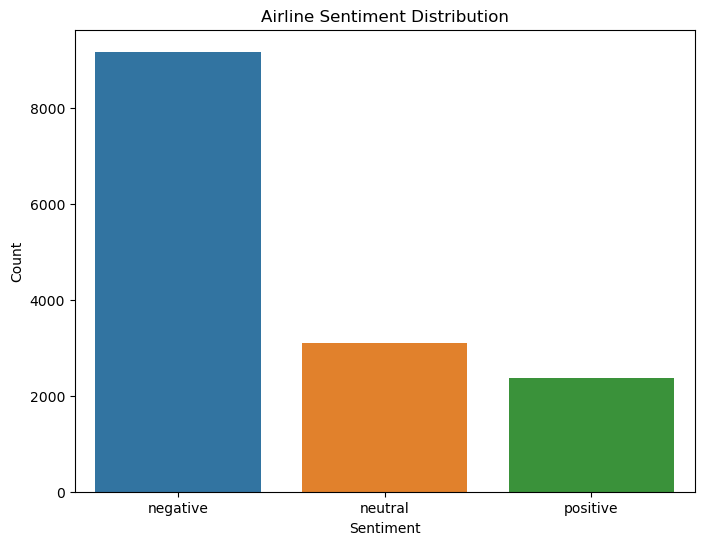

In [18]:
plt.figure(figsize = (8,6))
sns.countplot(data = df, x = 'airline_sentiment', order = ['negative', 'neutral', 'positive'])
plt.title('Airline Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

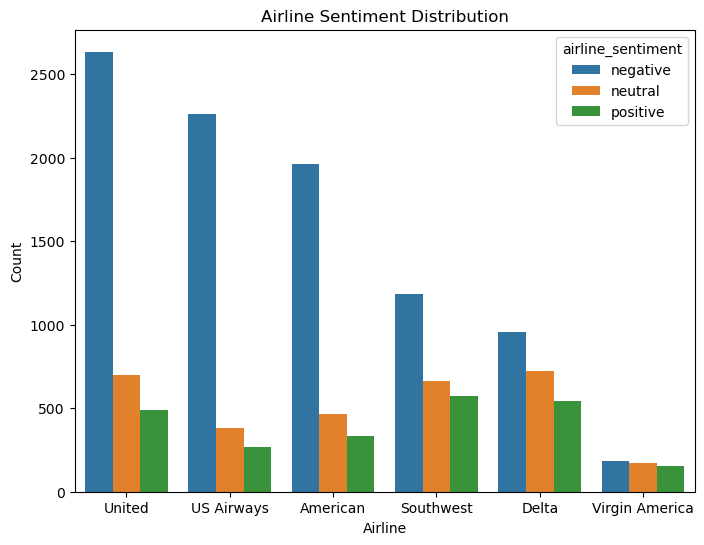

In [25]:
plt.figure(figsize = (8,6))
sns.countplot(data = df, x = 'airline', order = df['airline'].value_counts().index, hue_order = df['airline_sentiment'].value_counts().index, hue = 'airline_sentiment')
plt.title('Airline Sentiment Distribution')
plt.xlabel('Airline')
plt.ylabel('Count')

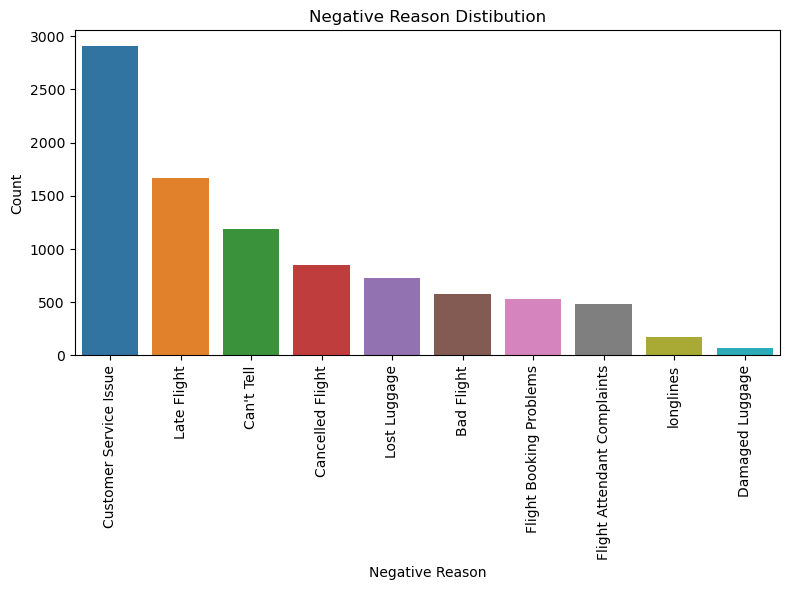

In [41]:
plt.figure(figsize = (8,6))
sns.countplot(data = df, x = 'negativereason', order = df['negativereason'].value_counts().index)
plt.title('Negative Reason Distibution')
plt.xlabel('Negative Reason')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()

In [42]:
import os
import openai
import json
import ast

# Put OpenAI API key in a separate text file in the same directory
with open('gpt_apikey.txt') as api_key:
    openai_key = api_key.readline()
client = openai.OpenAI(api_key = openai_key)

In [80]:
def analyze_sentiment(text):
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages =[
          {"role": "system", "content": "You are a sentiment analyser."},
          {"role": "user", "content": f"Please determine the sentiment of the following text: {text} Sentiment (positive, neutral or negative). Response should be one word, in lower case "}
      ]
    )
    sentiment = response.choices[0].message.content
    return sentiment

In [81]:
df100 = df.head(100)

In [82]:
df100['OpenAISentimentAnalysis'] = df100['text'].apply(analyze_sentiment)

/var/folders/vt/n5m4bwz90735jcwwpbgfrz0c0000gn/T/ipykernel_20458/2736683383.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df100['OpenAISentimentAnalysis'] = df100['text'].apply(analyze_sentiment)


In [83]:
print(df100[['airline_sentiment', 'OpenAISentimentAnalysis', 'text']])

   airline_sentiment OpenAISentimentAnalysis  \
0            neutral                positive   
1           positive                negative   
2            neutral                positive   
3           negative                negative   
4           negative                negative   
..               ...                     ...   
95          negative                negative   
96          negative                negative   
97          negative                negative   
98          negative                negative   
99          negative                negative   

                                                 text  
0                 @VirginAmerica What @dhepburn said.  
1   @VirginAmerica plus you've added commercials t...  
2   @VirginAmerica I didn't today... Must mean I n...  
3   @VirginAmerica it's really aggressive to blast...  
4   @VirginAmerica and it's a really big bad thing...  
..                                                ...  
95  @VirginAmerica Is it me, or

In [87]:
df100[df100['airline_sentiment'] != df100['OpenAISentimentAnalysis']][['text', 'airline_sentiment', 'OpenAISentimentAnalysis']]

,text,airline_sentiment,OpenAISentimentAnalysis
0,@VirginAmerica What @dhepburn said.,neutral,positive
1,@VirginAmerica plus you've added commercials t...,positive,negative
2,@VirginAmerica I didn't today... Must mean I n...,neutral,positive
7,@VirginAmerica Really missed a prime opportuni...,neutral,negative
10,@VirginAmerica did you know that suicide is th...,neutral,negative
27,@VirginAmerica do you miss me? Don't worry we'...,neutral,positive
29,@VirginAmerica LAX to EWR - Middle seat on a r...,neutral,negative
35,Nice RT @VirginAmerica: Vibe with the moodligh...,neutral,positive
38,@VirginAmerica when can I book my flight to Ha...,neutral,positive
41,"@VirginAmerica Hey, first time flyer next week...",negative,positive
